In [18]:
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from visualization.utils import defaultColors
from helpers import load_from_path, save_pdf

In [19]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import yaml

In [20]:
import seaborn as sns

cm = sns.light_palette("purple", as_cmap=True)
df = pd.read_excel('./final/GAS-004/XRD+synthsis_data.xlsx') 

df = df[
    [
        "Sample ID",
        "id",
        "pH",
        "C_ZnCl",
        "C_NaOH/C_ZnCl",
        "C_NaOH",
        "Q_AC",
        "Q_AIR",
        "N_ZnO",
        # "End",
        "Cond",
        "Aspect Ratio",
        "Peak Ratio",
        # "00n Size",
        # "Isotropic Size",
        # "2theta 1",
        # "2theta 2",
        # "2theta 3",
        # "2theta 4",
        # "Int. 1",
        # "Int. 2",
        # "Int. 3",
        # "Int. 4",
        # "Net Height_1",
        # "Net Height_2",
        # "Net Height_3",
        # "Net Height_4",
        # "pressure_air_std",
        # "pressure_b_std",
        # "pressure_b_mean",
        # "pressure_a_std",
        # "pressure_a_mean",
    ]
]
df.dropna(how="any", axis=1, inplace=True)

# only where C_NaOH/C_ZnCl is bigger than 1.6
# df = df[df["C_NaOH/C_ZnCl"] > 1.6]
df.reset_index(drop=True, inplace=True)

#format all float columns cheeck for string columns

# display(df
#         .select_dtypes(include=["float64", "int64"])
#         .style
#         .background_gradient(cmap=cm, axis=0).format("{:.2f}"))


df_mean = df.select_dtypes(include=["float64", "int64"]).groupby("id").mean()


df_std = df.select_dtypes(include=["float64", "int64"]).groupby("id").std()
# replace id index with first sample id of each id
# display(df_mean.style.background_gradient(cmap=cm))

from scipy.stats import norm

def calculate_var(mean, std_dev, alpha=0.9):

    # Calculate the z-score for the given alpha level
    z_score = norm.ppf(alpha)

    # Calculate mVaR for each variable
    var = mean - z_score * std_dev
    return var


# df_std_rel["Sample ID"] = df.groupby("id").first()["Sample ID"]
# df_std_rel = df_std_rel.set_index("Sample ID")

# display(df_std.style.background_gradient(cmap=cm))
# merge both dataframes with suffix _mean and _std
df_mean_std = pd.merge(
    df_mean, df_std, left_index=True, right_index=True, suffixes=("_mean", "_std")
)

for col in df_mean.columns:
    df_mean_std[col + "_VaR"] = calculate_var(
        df_mean_std[col + "_mean"], df_mean_std[col + "_std"]
    )

#make separate df for VaR
df_VaR = df_mean_std.filter(like="VaR", axis=1)
# display(df_mean.style.background_gradient(cmap=cm, axis=0).format("{:.2f}"))

# sort columns alphabetically
# df_mean_std = df_mean_std.reindex(sorted(df_mean_std.columns), axis=1)
df_mean_std["id_idx"] = df_mean_std.index
# drop all zerp columns
df_mean_std = df_mean_std.loc[:, (df_mean_std != 0).any(axis=0)]
# drop VaR columns if all VALUES are equal to mean columns VALUES
del df_mean_std["C_ZnCl_VaR"]
del df_mean_std["C_NaOH/C_ZnCl_VaR"]

df_mean_std["inital_sampling"] = df_mean_std["id_idx"] < 12
df["inital_sampling"] = df["id"] < 12

#reset index
df_mean_std.reset_index(drop=True, inplace=True)
 
# display(df_mean_std.style.background_gradient(cmap="Greens", axis=0).format("{:.2f}"))

Index(['pH_mean', 'C_ZnCl_mean', 'C_NaOH/C_ZnCl_mean', 'C_NaOH_mean',
       'Q_AC_mean', 'Q_AIR_mean', 'N_ZnO_mean', 'Cond_mean',
       'Aspect Ratio_mean', 'Peak Ratio_mean', 'pH_std', 'Cond_std',
       'Aspect Ratio_std', 'Peak Ratio_std', 'pH_VaR', 'C_NaOH_VaR',
       'Q_AC_VaR', 'Q_AIR_VaR', 'N_ZnO_VaR', 'Cond_VaR', 'Aspect Ratio_VaR',
       'Peak Ratio_VaR', 'id_idx', 'inital_sampling'],
      dtype='object')


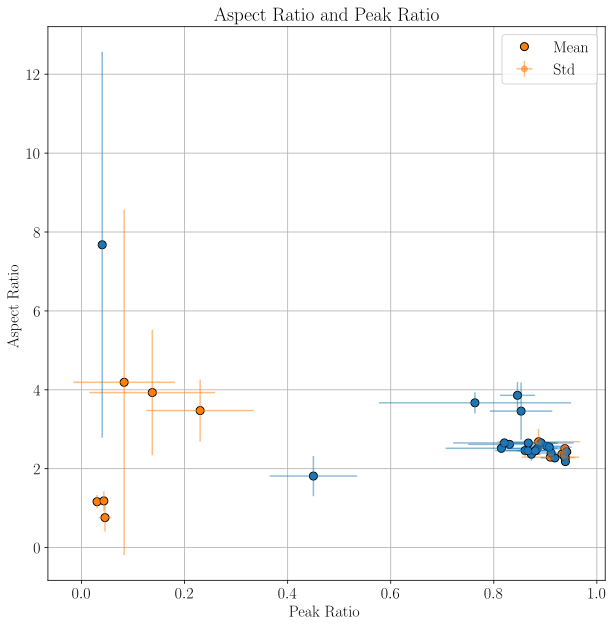

In [22]:
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# ax.plot(
#     df_mean_std["Peak Ratio_mean"],
#     df_mean_std["Aspect Ratio_mean"],
#     "o",
#     color=defaultColors[0],
#     markersize=8, markeredgecolor="black",
#     label="Mean",
# )
# ax.errorbar(
#     df_mean_std["Peak Ratio_mean"],
#     df_mean_std["Aspect Ratio_mean"],
#     xerr=df_mean_std["Peak Ratio_std"],
#     yerr=df_mean_std["Aspect Ratio_std"],
#     fmt="o",
#     color=defaultColors[0],
#     label="Std",
#     alpha=0.5,
# )


plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Helvetica"],
        # font size
        "font.size": 16,
    }
)
def is_float_column(column, df):
    return df[column].dtype in [np.float64, np.float32]

def get_color(column, df):
    labels = df[column]
    if is_float_column(column, df):
        # Use a continuous colormap for float-valued columns
        norm = plt.Normalize(labels.min(), labels.max())
        cmap = plt.cm.viridis
        colors = cmap(norm(labels))
        labels = labels.round(2)
    else:
        # Use distinct colors for category or integer-valued columns
        unique_labels = np.unique(labels)
        cmap = plt.cm.tab10
        colors_dict = {label: cmap(i) for i, label in enumerate(unique_labels)}
        colors = np.array([colors_dict[label] for label in labels])
        
    return colors, labels

print(df_mean_std.columns)
colors, labels = get_color("inital_sampling", df_mean_std)

# Aspect Ratio and Peak Ratio
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i, row in df_mean_std.iterrows():
    color = colors[i]
    ax.plot(
        row["Peak Ratio_mean"],
        row["Aspect Ratio_mean"],
        "o",
        color=color,
        markersize=8,
        markeredgecolor="black",
        label="Mean" if i == 0 else None,
    )
    ax.errorbar(
        row["Peak Ratio_mean"],
        row["Aspect Ratio_mean"],
        xerr=row["Peak Ratio_std"],
        yerr=row["Aspect Ratio_std"],
        fmt="o",
        color=color,
        label="Std" if i == 0 else None,
        alpha=0.5,
    )
ax.grid(True)
ax.set_xlabel("Peak Ratio")
ax.set_ylabel("Aspect Ratio")
ax.set_title("Aspect Ratio and Peak Ratio")
ax.legend()
plt.show()


# save_pdf(fig, path,"")